### 处理数据集

In [1]:
import pandas as pd
df = pd.read_csv(r"F:\文档\kaggle\rfm\sales.csv",engine="python")# ,index_col='USERID'
df.rename(str.lower,axis="columns",inplace=True)
df.orderdate = pd.to_datetime(df.orderdate,format="%Y-%m-%d")
# 删除有缺失值所在行
df.dropna(inplace=True,axis=0)
df.head()

,userid,orderdate,orderid,amountinfo
0,142074,2016-01-01,4196439032,9399.0
1,56927,2016-01-01,4198324983,8799.0
2,87058,2016-01-01,4191287379,6899.0
3,136104,2016-01-01,4198508313,5999.0
4,117831,2016-01-01,4202238313,5399.0


### 可视化
#### 根据流量指标和订单指标了解2016年用户消费情况
1. 了解每日订单量和每日订单金额的变化

           userid  amountinfo
count  347.000000  347.000000
mean   247.916427  184.838714
std     15.281423   25.036974
min    208.000000  118.186100
25%    237.000000  167.710650
50%    247.000000  185.132100
75%    258.500000  201.919500
max    300.000000  257.790700


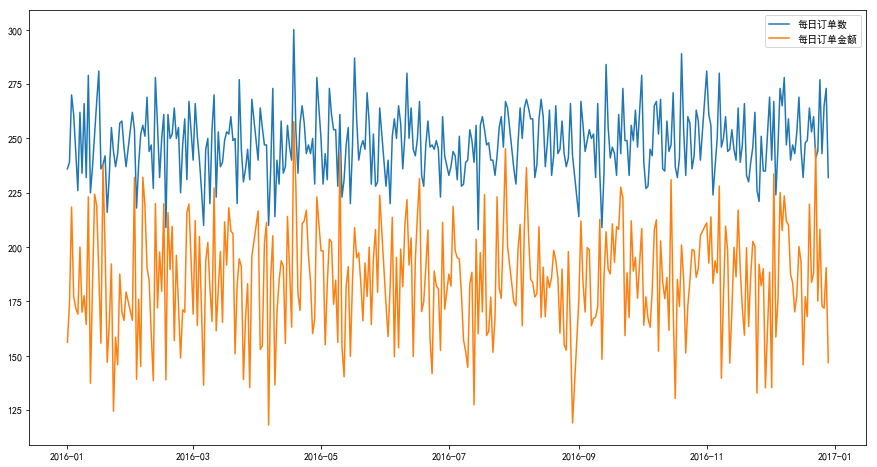

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(15,8))
# print(df.groupby(by="orderdate")["orderid"].count().reset_index().describe())
p = pd.merge(df.groupby(["orderdate"])["userid"].nunique().reset_index(),(df.groupby(by="orderdate")["amountinfo"].sum()/1000).reset_index(),how="outer",on="orderdate")
p.set_index("orderdate",inplace=True)
print(p.describe())
mpl.rcParams["font.sans-serif"] = ["SimHei"]
plt.plot(p)
plt.legend(["每日订单数","每日订单金额"])

- 由图可知，2016年每日订单金额波动较大，峰谷值在时间上总是相邻的出现，即前几天出现峰值后几天就会出现谷值，订单金额的平均值为184838元，极差和方差都偏大。 
- 订单数和订单金额的变化大致趋同，订单量相对于订单金额波动较小，平均值为248单，极差不超过30%。

2. 每月uv、每月订单量以及每月累计订单金额变化趋势

([<matplotlib.axis.XTick at 0x257bdbff400>,
 <a list of 13 Text xticklabel objects>)

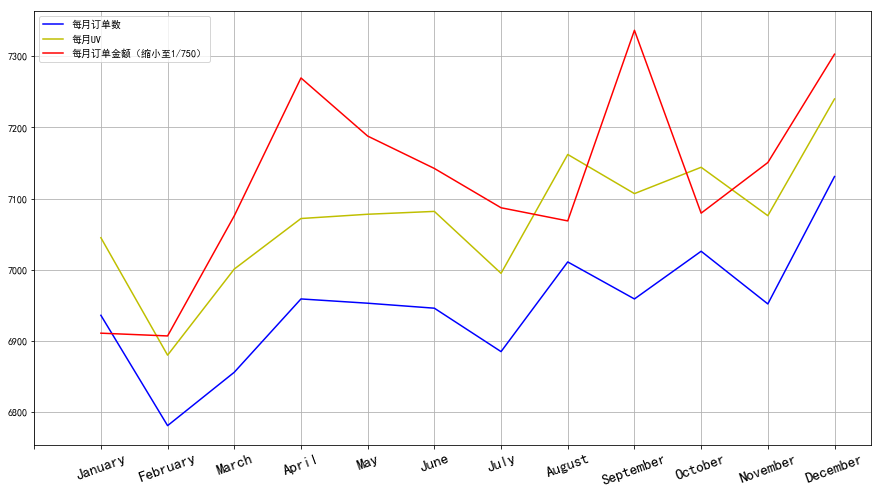

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import calendar

mpl.rcParams["font.sans-serif"] = ["SimHei"]
df["月份"]=df.orderdate.dt.month
plt.figure(figsize=(15,8))
plt.grid()
plt.plot(df.groupby(["月份"])["userid"].nunique(),color="b")
plt.plot(df.groupby(["月份"])["orderid"].nunique(),color="y")
plt.plot(df.groupby(["月份"])["amountinfo"].sum()/750,color="r")
plt.legend(["每月订单数","每月UV","每月订单金额（缩小至1/750）"])
plt.xticks(np.arange(13), calendar.month_name[0:13], rotation=20,size=15)

- 每月订单量和UV的变化基本上是同步的，最大的差异发生在2016年4月-6月，UV小幅上升但是订单量小幅下降，订单金额同时大幅下降，需要了解2016年4-6月之间页面是否做了什么变动或者推行了营销活动但是效果适得其反。
- 每月订单量和订单金额最大出入发生在2016年7月份到11月份，这个时间段订单量和订单金额是反向相关的，有接收了多笔大额订单，放弃了大量小额订单的可能，需要进一步确认是什么原因。

### 复购率
- 每月复购率
- 季度复购率
- 2016年复购率

每月复购率为:0.16%
季度复购率为:11.89%
2016年复购率为:32.88%


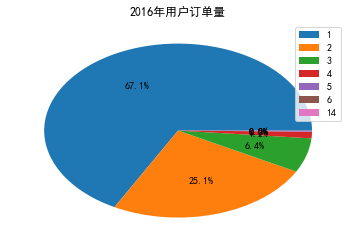

In [4]:
# 用户总订单量
plt.pie(df.groupby(by="userid")["orderid"].count().value_counts(),autopct="%3.1f%%")
labels=[1,2,3,4,5,6,14]
plt.legend(labels,loc=0)
plt.title("2016年用户订单量")
# 每月复购率
mon_rebuy = (df.groupby(["orderdate","userid"])["userid"].count() >1).sum()/df.userid.nunique()
print("每月复购率为:{}%".format(round(mon_rebuy*100,2)))
# 季度复购率
df["季度"] = pd.cut(df['月份'],bins=4,labels=["第一季度","第二季度","第三季度","第四季度"])
quarter_rebuy = (df.groupby(["季度","userid"])["userid"].count()>1).sum()/df.userid.nunique()
print("季度复购率为:{}%".format(round(quarter_rebuy*100,2)))
# 2016年复购率
year_rebuy = (df.groupby(["userid"])["userid"].count()>1).sum()/df.userid.nunique()
print("2016年复购率为:{}%".format(round(year_rebuy*100,2)))

- 根据饼状图可知，67.1%的用户在2016年只有1次订单，25%的客户有2次订单，剩下7%左右的客户下单次数超过2次，其中有下单次数为14的忠实客户。
- 月度复购率并不高，不过还需要结合商品特性，如果是耐用品短周期内的复购率低是很正常的。
- 季度和年度相对正常。

### 计算RFM指标
- R 2016年最后一次订单是在什么时候，距离2017.1.1的间隔天数
- F 2016年的购买频次
- M 2016年累计购买金额

In [5]:
import datetime

RFM = pd.DataFrame()
RFM = df.groupby(["userid"])["orderdate"].max().reset_index()
RFM.rename(columns={"orderdate":"last_orderdate"},inplace=True)
RFM["R"] = RFM["last_orderdate"].apply(lambda x:(datetime.datetime(2017,1,1)-x).days)
RFM.drop(axis=1,columns="last_orderdate",inplace=True)
# print((df.groupby(by="userid")["orderid"].nunique()>1).sum())# 等同于(df.groupby(by=["userid"])["orderid"].count()>1).sum()
df.orderid.nunique()# 76042
df.shape# 86125
df.userid.nunique()# 60496
df.groupby(by=["orderid","userid"])["orderid"].count()# 怎么理解一个订单号对应两个或以上的用户id呢？
RFM = pd.merge(RFM,df.groupby(by="userid")["orderid"].nunique().reset_index(),how="outer",on="userid")
RFM.rename(columns={"orderid":"F"},inplace=True)
RFM = pd.merge(RFM,df.groupby(["userid"])["amountinfo"].sum().reset_index(),how="outer",on="userid")
RFM.rename(columns={"amountinfo":"M"},inplace=True)
print(RFM.info())
RFM.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60496 entries, 0 to 60495
Data columns (total 4 columns):
userid    60496 non-null int64
R         60496 non-null int64
F         60496 non-null int64
M         60496 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.3 MB
None


,userid,R,F,M
count,60496.000000,60496.000000,60496.000000,60496.000000
mean,107957.967717,160.982412,1.423648,1060.219415
std,32894.016615,104.170078,0.688341,1804.189422
min,51220.000000,3.000000,1.000000,0.500000
25%,79403.750000,70.000000,1.000000,22.400000
50%,107941.500000,149.000000,1.000000,119.000000
75%,136303.000000,247.000000,2.000000,1499.000000
max,165100.000000,366.000000,14.000000,89766.800000


### 分类
RFM模型分类的方法：
1. 可以简单的根据该指标的平均数或者中位数来判断用户的该指标是高还是低。
2. 利用K_means 聚类给RFM模型分层，原理是根据欧式距离判断用户归类于哪个价值层次。
3. 决策树以三个指标为特征加入树模型中分类。 

我采用的是K_means 聚类

步骤1. 首先单独提取RMF中的frequency，monetary，和recency三个字段进行聚类，组成数组rfm。 

步骤2. 设置K_means模型参数，并加入数据rfm进行训练,得到每个用户的聚类标记。 

步骤3. 将kmeans模型得到的标记label_合并到RFM中。 

步骤4. 分类

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

rfm = np.array(RFM[["R","F","M"]])
clf = KMeans(n_clusters=8,random_state=0)
clf.fit(rfm)
# print(clf.labels_)# kmeans模型得到的价值阶段label
RFM["label"] = clf.labels_
# 查看RFM模型中8个类别的客户数量
centers=pd.DataFrame(clf.cluster_centers_)# 聚类质心点
count = RFM["label"].value_counts()
df_new = pd.concat([centers,count],axis=1)
df_new.columns=["R","F","M","客户数量"]
print(df_new)
# 模型评分
# print(silhouette_score(RFM,clf.labels_))# RFM.values
# rfm_new=RFM[["R","F","M"]]
# clf=KMeans(n_clusters=8,random_state=0)
# clf=clf.fit(RFM)
# RFM['label']=clf.labels_
# num=RFM['label'].value_counts()
# centers=pd.DataFrame(clf.cluster_centers_)
# rfm_new2=pd.concat([centers,num],axis=1)
# rfm_new2.columns=list(RFM.columns)+['客户数量']
# print(rfm_new2)
# print(silhouette_score(rfm_new,clf.labels_))

            R          F             M   客户数量
0  148.701661   1.637758   3595.845043   5477
1  166.833300   1.298884     98.515282  40505
2  125.020661   2.115702   7685.019318    968
3  153.151779   1.588451   1120.328123   5731
4    6.000000  14.000000  89766.800000      1
5  139.567128   1.914565   5067.548983   2458
6  114.006757   2.385135  12939.683784    148
7  155.168203   1.597350   2329.614535   5208


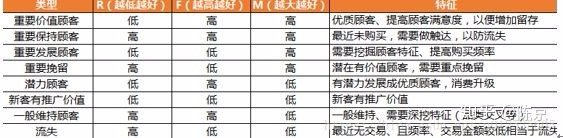

In [8]:
rmd=df_new['R'].median()
fmd=df_new['F'].median()
mmd = df_new['M'].median()

for i in range(RFM.shape[0]):
    if RFM.loc[i,'R']<=rmd and RFM.loc[i,'F']>fmd and RFM.loc[i,'M']>=mmd:
        RFM.loc[i,'客户类型'] = '重要高价值客户'
    elif RFM.loc[i,'R']>rmd and RFM.loc[i,'F']>fmd and RFM.loc[i,'M']>=mmd:
        RFM.loc[i,'客户类型'] = '重要保持客户'
    elif RFM.loc[i,'R']<=rmd and RFM.loc[i,'F']<=fmd and RFM.loc[i,'M']>=mmd:
        RFM.loc[i,'客户类型'] = '重要发展客户'
    elif RFM.loc[i,'R']>rmd and RFM.loc[i,'F']<=fmd and RFM.loc[i,'M']>=mmd:
        RFM.loc[i,'客户类型'] = '重要挽留客户'
    elif RFM.loc[i,'R']<=rmd and RFM.loc[i,'F']>fmd and RFM.loc[i,'M']<mmd:
        RFM.loc[i,'客户类型'] = '潜力客户'
    elif RFM.loc[i,'R']<=rmd and RFM.loc[i,'F']<=fmd and RFM.loc[i,'M']<mmd:
        RFM.loc[i,'客户类型'] = '推广价值新客户'
    elif RFM.loc[i,'R']>rmd and RFM.loc[i,'F']>fmd and RFM.loc[i,'M']<mmd:
        df_new.loc[i,'客户类型'] = '一般维持客户'
    elif RFM.loc[i,'R']>rmd and RFM.loc[i,'F']<=fmd and RFM.loc[i,'M']<mmd:
        RFM.loc[i,'客户类型'] = '已流失客户'
# print(RFM)


已流失客户      0.246259
推广价值新客户    0.171814
重要高价值客户    0.169871
重要挽留客户     0.162576
重要发展客户     0.111395
重要保持客户     0.073832
潜力客户       0.064253
Name: 客户类型, dtype: float64


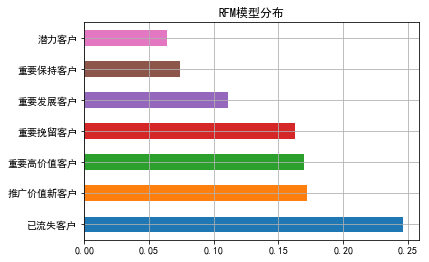

In [9]:
data=RFM.客户类型.value_counts(normalize=1)
print(data)
data.plot(kind="barh",title="RFM模型分布",grid=True)

## 结论
1. 根据RFM模型可知接近25%的客户已成为流失客户，一方面需要定期激活新近用户的购买欲，另一方面提高老客户的复购率。
2. 近期新客户较多，建议多举办推广营销活动，提高新增客户的留存率。
3. 重要价值客户属于优质客户，忠实度较高，占17%左右，需要保证这部分客户的满意度，保持留存率。
4. 重要挽留客户是最近未消费、消费频率低但是消费金额较高的客户群体，需要重点挽留。
5. 重要发展客户是最近有消费且交易金额较大但是消费频次较低的客户群体，重点挖掘该客户特征，提高消费频次。
6. 重要保持客户消费的频次较高且交易金额大，但是最近未有消费记录，需要重点做触达以防流失。
7. 潜在客户是指消费频次高且最近有交易记录，但是消费金额较小的客户群体，对其做消费升级，很有可能发展成高价值客户。